In [1]:
import numpy as np
from gurobipy import Model,GRB

In [2]:
lp_priori = Model()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-11


In [3]:
a1 = np.arange(15,29)
a2 = np.arange(3,19)
c = np.array([3,2])

In [4]:
x = lp_priori.addVars(2)

In [5]:
# box uncertainty
lp_priori.addConstr(np.max(a1)*x[0] + np.max(a2)*x[1] <= 50)

<gurobi.Constr *Awaiting Model Update*>

In [6]:
lp_priori.setObjective( sum(c[i]*x[i] for i in range(2)), GRB.MAXIMIZE)

In [7]:
lp_priori.optimize()
print("-----------------------------")
print("objective = ",np.round(lp_priori.objVal,2))
print("x: ",np.round([x[s].X for s in range(2)],2))

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 1 rows, 2 columns and 2 nonzeros
Model fingerprint: 0x4ab8242e
Coefficient statistics:
  Matrix range     [2e+01, 3e+01]
  Objective range  [2e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+01, 5e+01]
Presolve removed 1 rows and 2 columns
Presolve time: 0.03s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5555556e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.05 seconds (0.00 work units)
Optimal objective  5.555555556e+00
-----------------------------
objective =  5.56
x:  [0.   2.78]


In [8]:
import pandas as pd
df = pd.read_csv("sample-linear-lp-ddro.csv")
df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,20.653077,18.483860,21.446036,20.537396,20.673170,18.211768,19.891635,21.739912,19.053237,18.378939,...,20.762971,21.016020,20.507729,21.078919,19.642891,20.044467,17.159307,19.847692,19.364625,19.567162
1,11.954259,6.803893,11.352690,10.790166,10.977059,6.850167,9.517575,13.341648,8.404158,5.217831,...,10.378968,11.070541,11.770835,12.368959,10.317354,9.820686,6.328218,10.154187,9.845467,8.331373


In [9]:
a = df.to_numpy()

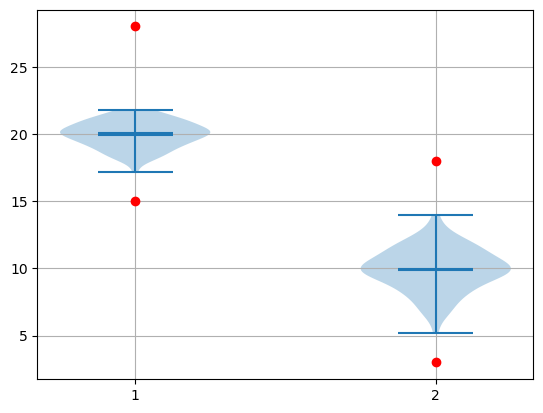

In [10]:
import matplotlib.pyplot as plt
sig, axes = plt.subplots()
axes.violinplot(a.T,showmeans=True, showmedians=True, showextrema=True)

plt.plot(1,np.min(a1),'o',color='red')
plt.plot(1,np.max(a1),'o',color='red')

plt.plot(2,np.min(a2),'o',color='red')
plt.plot(2,np.max(a2),'o',color='red')

plt.xticks([1,2])
plt.grid()

plt.show()

# Steps of Algorithm:
1. whitening Matrix (Q)
2. Kernel Matrix
3. Solve (QP) ====> SV, BSV
4. Build and Solve Data-driven Robust Counterpart

In [13]:
def whitening_matrix(X):
    sigma = np.cov(X, rowvar=True) # [M x M]
    U,S,V = np.linalg.svd(sigma)
    epsilon = 1e-5
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    return ZCAMatrix

In [14]:
Q = whitening_matrix(a)

In [15]:
Q

array([[ 1.79482344, -0.71216933],
       [-0.71216933,  0.94292921]])

In [18]:
# kernel matrix
l_psd = np.zeros(a.shape[0])
for i in range(a.shape[0]):
    l_ub = np.max(np.dot(Q[i,:].T,a))
    l_lb = np.min(np.dot(Q[i,:].T,a))
    l_psd[i] = l_ub - l_lb + .0001

In [19]:
l_psd

array([4.39112423, 5.85928802])

In [21]:
ker_mat = np.zeros((a.shape[1],a.shape[1]))

In [24]:
for u in range(a.shape[1]):
    for v in range(a.shape[1]):
        ker_mat[u,v] = np.sum(l_psd) - np.linalg.norm(np.dot(Q,a[:,u] - a[:,v]),1)

In [25]:
ker_mat

array([[10.25041225,  6.71340264,  7.26681403, ...,  8.9630738 ,
         8.36883906,  6.97656134],
       [ 6.71340264, 10.25041225,  5.99372006, ...,  8.00074109,
         7.42437706,  8.72509002],
       [ 7.26681403,  5.99372006, 10.25041225, ...,  8.22701487,
         7.5269303 ,  7.51904229],
       ...,
       [ 8.9630738 ,  8.00074109,  8.22701487, ..., 10.25041225,
         9.55032768,  7.93676219],
       [ 8.36883906,  7.42437706,  7.5269303 , ...,  9.55032768,
        10.25041225,  7.23667762],
       [ 6.97656134,  8.72509002,  7.51904229, ...,  7.93676219,
         7.23667762, 10.25041225]])

In [26]:
np.linalg.eigvals(ker_mat)

array([8.05313930e+02, 6.21718923e+01, 5.71245993e+01, 2.05169589e+01,
       1.51786372e+01, 1.04211268e+01, 8.55444387e+00, 5.36724349e+00,
       4.99232168e+00, 3.68285557e+00, 3.09565548e+00, 2.60707736e+00,
       2.33258097e+00, 2.01561996e+00, 1.75168596e+00, 1.64877847e+00,
       1.44321332e+00, 1.32673844e+00, 1.02145773e+00, 9.93536933e-01,
       9.35206704e-01, 7.40853690e-01, 7.19449871e-01, 6.83997162e-01,
       6.44013618e-01, 5.89823108e-01, 5.35282712e-01, 4.81075847e-01,
       4.47542744e-01, 4.44316206e-01, 4.04478889e-01, 3.68828256e-01,
       3.46687442e-01, 3.30334618e-01, 3.12180233e-01, 2.89955269e-01,
       2.66859495e-01, 2.53019662e-01, 2.21192346e-01, 2.15586453e-01,
       2.02728385e-01, 1.97329891e-01, 1.75917246e-01, 1.73317816e-01,
       1.62567816e-01, 1.48282282e-01, 1.41462412e-01, 1.39325257e-01,
       1.33605707e-01, 1.23173305e-01, 1.19426790e-01, 1.17817487e-01,
       1.11242116e-01, 1.03971726e-01, 1.00275913e-01, 9.87539733e-02,
      

In [27]:
# SVC (QP)
svc = Model("support-vector-clustering")

In [28]:
p_regul = .1
n_samples = a.shape[1]
p_ker_mat = ker_mat

In [29]:
v_alpha = svc.addVars(n_samples, lb=0, ub=1/(n_samples*p_regul))

In [30]:
svc.addConstr(sum(v_alpha[i] for i in range(n_samples)) == 1)

<gurobi.Constr *Awaiting Model Update*>

In [31]:
svc.setObjective( sum(v_alpha[i]*v_alpha[j]*p_ker_mat[i,j] for i in range(n_samples)
                      for j in range(n_samples)) - 
                 sum(v_alpha[i]*p_ker_mat[i,i] for i in range(n_samples)) )

In [32]:
svc.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 1 rows, 100 columns and 100 nonzeros
Model fingerprint: 0x6a785662
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 1e+01]
  QObjective range [1e+01, 4e+01]
  Bounds range     [1e-01, 1e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.03s
Presolved: 1 rows, 100 columns, 100 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 99
 AA' NZ     : 4.950e+03
 Factor NZ  : 5.050e+03
 Factor Ops : 3.384e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.42038353e+05 -2.03264

In [33]:
v_alpha_array = np.round([v_alpha[s].X for s in range(n_samples)],2)

In [34]:
print(v_alpha_array)

[0.   0.   0.   0.   0.   0.   0.   0.07 0.   0.1  0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.03 0.
 0.   0.   0.   0.1  0.   0.   0.1  0.   0.   0.   0.   0.   0.   0.03
 0.04 0.   0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.1  0.
 0.   0.   0.   0.   0.   0.09 0.   0.   0.   0.06 0.   0.   0.   0.
 0.07 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.1  0.
 0.   0.  ]


In [37]:
SV = np.where(v_alpha_array > 0)
BSV = np.where( (v_alpha_array > 0) & (v_alpha_array < 1/(n_samples*p_regul)) ) 
print(SV)
print(BSV)

(array([ 7,  9, 26, 31, 34, 41, 42, 44, 68, 75, 79, 84, 96], dtype=int64),)
(array([ 7, 26, 41, 42, 75, 79, 84], dtype=int64),)


In [38]:
SV = np.array(SV).ravel()
BSV = np.array(BSV).ravel()

In [39]:
print(SV)
print(BSV)

[ 7  9 26 31 34 41 42 44 68 75 79 84 96]
[ 7 26 41 42 75 79 84]


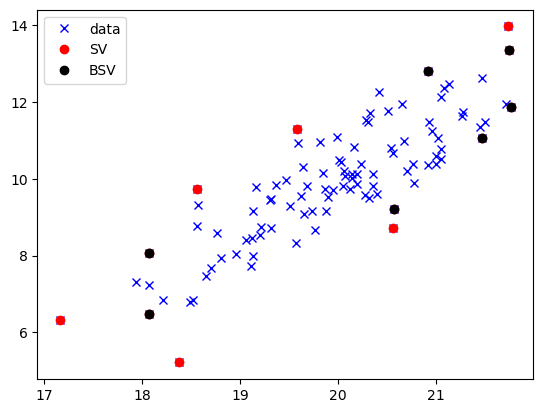

In [40]:
plt.plot(a[0,:],a[1,:], 'x',color='blue',label="data")
plt.plot(a[0,SV],a[1,SV], 'o',color='red',label="SV")
plt.plot(a[0,BSV],a[1,BSV], 'o',color='black',label="BSV")
plt.legend()
plt.show()

# Data-driven Robust Counterpart

In [62]:
p_alpha_SV = v_alpha_array[SV]
p_a_SV = a[:,SV]
p_a_BSV = a[:,BSV]

In [63]:
ddro = Model("data-driven-robust-opt-svc")

In [64]:
n_SV = SV.size
n_BSV = BSV.size

In [65]:
print(n_BSV)

7


In [66]:
p_rhs = 50

In [67]:
p_obj = np.array([3,2])

In [68]:
p_theta_vec = np.zeros(n_BSV)
for ip in range(n_BSV):
    p_theta_vec[ip] = np.sum([p_alpha_SV[i]*np.linalg.norm(np.dot(Q,p_a_BSV[:,ip]-p_a_SV[:,i]),1) for i in range(n_SV)])

In [69]:
p_theta = np.min(p_theta_vec)
print(p_theta)

3.6159276707843864


In [70]:
v_dual_eta = ddro.addVar()
v_primal_x = ddro.addMVar(2)
v_dual_la = ddro.addMVar((2,n_SV))
v_dual_mu = ddro.addMVar((2,n_SV))

In [71]:
ddro.setObjective(p_obj @ v_primal_x, GRB.MAXIMIZE)

In [72]:
ddro.addConstr(sum(np.dot(Q,p_a_SV[:,i]).T @ v_dual_la[:,i] for i in range(n_SV)) -
               sum(np.dot(Q,p_a_SV[:,i]).T @ v_dual_mu[:,i] for i in range(n_SV)) + v_dual_eta*p_theta <= p_rhs)

<MConstr ()>

In [73]:
for j in range(2):
    for i in range(n_SV):
        ddro.addConstr(v_dual_la[j,i] + v_dual_mu[j,i] == v_dual_eta*p_alpha_SV[i])

In [74]:
ddro.addConstr( sum(Q @ v_dual_la[:,i] for i in range(n_SV)) -
               sum(Q @ v_dual_mu[:,i] for i in range(n_SV)) - v_primal_x == 0)

<MConstr (2,) *awaiting model update*>

In [75]:
ddro.optimize()
status = ddro.status
if status == GRB.OPTIMAL:
    print("-----------------------------")
    print("objective = ",np.round(ddro.objVal,2))
    print("x: ",np.round([v_primal_x[s].X for s in range(2)],2))

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 29 rows, 55 columns and 237 nonzeros
Model fingerprint: 0x2cdbcca8
Coefficient statistics:
  Matrix range     [3e-02, 3e+01]
  Objective range  [2e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+01, 5e+01]
Presolve time: 0.01s
Presolved: 29 rows, 55 columns, 237 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0000000e+30   2.000000e+30   5.000000e+00      0s
      13    7.5549649e+00   0.000000e+00   0.000000e+00      0s

Solved in 13 iterations and 0.02 seconds (0.00 work units)
Optimal objective  7.554964854e+00
-----------------------------
objective =  7.55
x:  [0.   3.78]


# a priori model (BOX)

objective =  5.56

x:  [0.   2.78]

# a posteriori model (DDRO)

objective =  7.55

x:  [0.   3.78]